In [1]:
import pandas as pd

# make sure you imported the kaggle dataset and have it on the same directory as this. 
file = "../raw_data/wiki_movie_plots_deduped.csv"

dataFrame = pd.read_csv(file) #like 2d array 


# Some Debug Functions (to filter and mess with data)

In [2]:
def displayFromDataFrame(frame, numValues, keyF):
    """using pandas dataframe object created from a csv file, look at each movie/thing (by row)
        by key param it will print the first n values in the dataframe 
        use: to better understand pandas 
    """
    for index, row in frame.iterrows():   #frame is a pandas dataframe of a csv file framX["ColumnName"][index] 
        if index >= numValues:
            break
        value = row[keyF]
        print(value)
"""
rows genre txt
0     x     ....
"""

#my funct from past hw
def remove_nested_brackets(text):
    # Regular expression to match and remove content within nested square brackets
    square_brackets_pattern = r'\[[^\[\]]*\]'
    
    # Regular expression to match and remove content within nested angle brackets
    angle_brackets_pattern = r'<[^<>]*>'
    
    # Define a function to recursively remove nested brackets
    def remove_nested(text):
        # Remove content within square brackets
        text_without_square_brackets = re.sub(square_brackets_pattern, '', text)
        # Remove content within angle brackets
        text_without_angle_brackets = re.sub(angle_brackets_pattern, '', text_without_square_brackets)
        
        # Check if there are any nested brackets left
        if re.search(square_brackets_pattern, text_without_angle_brackets) or re.search(angle_brackets_pattern, text_without_angle_brackets):
            # If nested brackets are found, recursively remove them
            return remove_nested(text_without_angle_brackets)
        else:
            # If no more nested brackets are found, return the modified text
            return text_without_angle_brackets

    # Call the recursive function
    result = remove_nested(text)
    return result


print("functions initialized")

functions initialized


# Gather the movies into the genrePlot dictionary 

In [3]:
# Gather the ,movies into the genrePlot dictionary 

selected_col = dataFrame[["Genre", "Plot"]] # columns from the csv that we want to focus on

selected_genres = ["comedy", "drama", "adventure", "fantasy", 
                  "horror", "mystery", "romance", 
                 "action", "thriller", "western"] # select 10 genres

#dict
genre_plot = {}

#iter through rows (movie) in data frame 
for index, row in selected_col.iterrows():
    curGenre = row['Genre']
    curPlot = row['Plot']
    
    if curGenre not in selected_genres:     
        #skip over this movie if it's genre is not one we're looking for 
        continue    
    if curGenre not in genre_plot:          
        #if cur movies genre hasn't been added to dict yet -> add that genre title with that plot as it's value
        genre_plot[curGenre] = [curPlot]
    elif len(genre_plot[curGenre]) < 250:
        #since this genre is in the dict -> now make sure that genre key hasn't surpassed having 250 entries 
        genre_plot[curGenre].append(curPlot)
            

# LLX CODE FOR PROJECT:

## Frequency (filtered) Remove Generics like names and other people nouns
- source: https://gist.github.com/sebleier/554280 
- txt file with stop list should be included in rep 
- note: remember to keep stop words lowercase..

In [4]:
from nltk.corpus import stopwords 
stopList = ["dsfds"]

basic = [")", "(", ".", ",", "?", "could", "would", "“", "”", "’", ";", "!","much", "like", "one", "many", "though", "without", "upon"]

smallCases = ["''", "``", "'s", 'get', 'also', "'", "–"]

names = ["jim", "john", "jack", "harry", "chan", "tom", "gene", "keaton", "harold", "charlie", "buster", "paul", "billy", "martin", "david", "kate", "george", "joe", "alice", "anne", "roy", "frank", "sara", "walter", "michael", "helen", "lori", "karl", "chris", "henry", "mike", "susan", "laura", "scott", "clifford", "peter", "sally", "tracy", "lisa"]

nouns = ["man", "woman", "father", "mother", "son", "daughter", "husband", "wife", "girl", "dr.", "mrs.", "men"]

print("done")

done


### Generating regular stop list
- variable for either route set as: stopList

In [5]:
#ini basic stop words list, added some after extra filtering deemed to be necessary 
stopList.extend([w for w in basic if w not in stopList])
stopList.extend([w for w in smallCases if w not in stopList])
print(len(stopList)) #27

27


### Generating Extensive stop list
- first: extends stoplist with words in massive text file 
- var: stopList

#### read from text file (run once)

In [7]:
with open("../extensiveStopList.txt", "r", encoding='utf=8') as fileO:
    extensiveStopListTxt = fileO.read()

In [8]:
#can only run once for now..
filterStop = extensiveStopListTxt.split(",")
if len(filterStop) == 1160:
    print("Success: created extensiveStopList variable")
stopList.extend(filterStop) #warning: iffy
print("done")

Success: created extensiveStopList variable
done


#### names and nouns

In [9]:
#NAMES
stopList.extend([w for w in names if w not in stopList])
print("done")

done


In [10]:
stopList.extend([w for w in nouns if w not in stopList])
print("done")

done


### remove 

In [15]:
#iterate through each large genre list -> textChunk -> tokens -> noStopTokens -> unigram -> freq object 
genreUnigrams = {} #reset from potential past set dict 
wordCount = 20


#DONT USE ANYMORE -> use regular unigram w stop list made in this section instead as a param 
def nameFilteredUnigram(functWordCount, displayBool):
    curGenreUnigramObj = {}
    for curGenre in selected_genres:
        plotsList = genre_plot[curGenre]
        genresTexts = " ".join(plotsList) #now text chunk
        #remove spacing
        genresTexts = re.sub(r'[\n|\s]+', ' ', genresTexts)
        genresTexts = remove_nested_brackets(genresTexts)
        #tokenize
        tokens = nltk.word_tokenize(genresTexts)
        #remove stop words 
        noStop_tokens = [w for w in tokens if w.lower() not in filterStop]
        #unigram the genre 
        #iterate through top ten object to (potentially) display unigram findings 
        popularWords = printUnigramData(curGenre, noStop_tokens, functWordCount, displayBool) #creates and prints 
        #print(noStop_tokens)
        curGenreUnigramObj[curGenre] = [noStop_tokens, popularWords]
    return curGenreUnigramObj
print("ini: funct to return filtered dictionary with unigrams")

###NOTE: this block still modifies genreUnigrams (intended)
genreUnigrams = nameFilteredUnigram(wordCount, False)
print("Done")

ini: funct to return filtered dictionary with unigrams
Done


## Goal: Create unigrams for the 10 different genres 
- create word clouds with this 
- where original frequency filtering code is located! 

In [14]:
import nltk, re, glob
from nltk.stem import WordNetLemmatizer

lemma = WordNetLemmatizer()

#generate and print frequency for words in a UNIGRAM for genre topic (TAKES TOKEN AS INPUT):
#return: list of top n tokens (no count for them..) 
def printUnigramData(curGenre, tokens, n, printBool):
    #param: already a freq dist 
    #n: top 10 or more values to print out
    #return: a list of the top values 
    unigram = nltk.ngrams(tokens, 1)
    unigramL = list(unigram)
    unigramFreq = nltk.FreqDist(unigramL)
    if printBool:
        print("Genre:", curGenre, "(most frequently occuring words found)")
    popularWords = []
    popularUnigrams = unigramFreq.most_common(n)
    for unigramObj in popularUnigrams:
        unigram = unigramObj[0]
        if printBool:
            print(unigram[0]) #, unigramObj[1]) #name of word and freq of word 
        popularWords.append(unigram[0])
    if printBool:
        print()
    return popularWords

#iterate through each large genre list -> textChunk -> tokens -> noStopTokens -> unigram -> freq object 
def regFilteredUnigram(functWordCount, displayBool, functStopList):
    curGenreUnigramObj = {}
    for curGenre in selected_genres:
        #create genre text chunk (required)
        plotsList = genre_plot[curGenre]
        genresTexts = " ".join(plotsList)
        
        #remove spacing (required)
        genresTexts = re.sub(r'[\n|\s]+', ' ', genresTexts)
        genresTexts = remove_nested_brackets(genresTexts)
        
        #tokenize (required)
        tokens = nltk.word_tokenize(genresTexts)
        
        #remove stop words (optional)
        tokens = [w for w in tokens if w.lower() not in functStopList] #noStop_tokens
        
        #LEMMATIZE (optional)
        tokens = [lemma.lemmatize(w) for w in tokens] #lemma_noStop_tokens
        
        #UNIGRAM THE CURRENT GENRE 
        #iterate through X amount in freq (can display unigram findings if bool in funct set to true)  
        popularWords = printUnigramData(curGenre, tokens, functWordCount, displayBool) #CREATES AND PRINTS TOP 10 (or more now) 
        #return dict -> key: "genreName" value: array[ itstokens,  ]
        curGenreUnigramObj[curGenre] = [tokens, popularWords]
    return curGenreUnigramObj
print("ini: funct's for creating and printing unigram initialized")

ini: funct's for creating and printing unigram initialized


In [16]:
#NOTE: genreUnigrams (now filled by funct above )
#add word count and true if you want to print results..
genreUnigrams = regFilteredUnigram(15, False, stopList)
print("genreUnigrams has been set")

#genreUnigrams dict: GENRE{ filtered tokens , popular words }
#comedy, drama, adventure, fantasy, horror, mystery, romance,action, thriller, western

genreUnigrams has been set


## Word Cloud  

killed
action
['police', 'killed', 'gang', 'kill', 'car', 'fight', 'escape', 'death', 'kills', 'takes', 'finds', 'group', 'killing', 'named', 'friend']


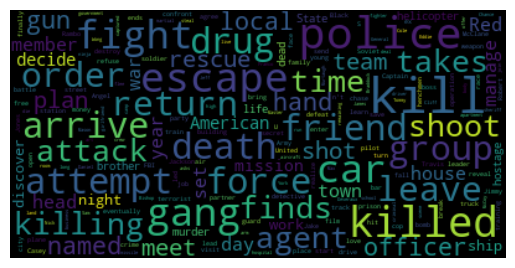

adventure
['ship', 'love', 'King', 'island', 'crew', 'takes', 'Tarzan', 'time', 'killed', 'finds', 'return', 'captain', 'Captain', 'death', 'escape']


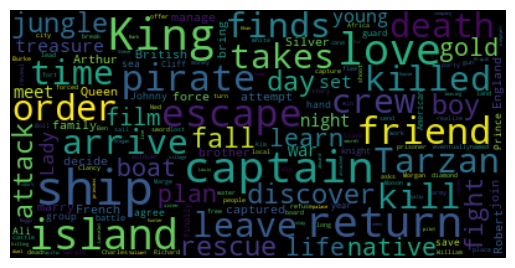

In [70]:
#Wordcloud
import matplotlib.pyplot as plt 
from wordcloud import WordCloud

def createCloud(tokens_as_string):
    wordcloud = WordCloud(max_font_size=40, collocations=False).generate(tokens_as_string)
    plt.figure
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#using genreUnigrams obj in function
def displayGenreInfo(genre):
    print(genre)
    print(genreUnigrams[genre][1])
    genreTokens = genreUnigrams[genre][0]
    genreTxt = " ".join(genreTokens)
    createCloud(genreTxt)

#redundant???
def compareTwo(*argv):
    for arg in argv:
        displayGenreInfo(arg)

print(lemma.lemmatize("killed"))
        
compareTwo("action", "adventure")

#0: tokens | 1: popular words calculated earlier 
#comedy, drama, adventure, fantasy, horror, mystery, romance,action, thriller, western

In [ ]:
#create a more official representation of data  ???

## Compare Word Frequencies:
- goal is to make functions to easily print, formatted, the frequencies generated earlier 
- done: output is clean

In [444]:
import numpy as np

def compareFreq(*argv):
    freqArray = []
    totalGenres = 0
    for genre in argv:
        freqArray.append(genreUnigrams[genre][1])
        totalGenres+=1
    titleStr = "{:15} "*totalGenres
    print(titleStr.format(*argv))
    print("~"*16*totalGenres)
    freqArray = np.array(freqArray)
    
    dataInRowCount = len(freqArray[0])
    #freqArray = freqArray.reshape(dataInRowCount, totalGenres)   #was wrong this whole time 
    freqArray = freqArray.T
    dataInRowCount = len(freqArray[0])
    
    for row in freqArray:
        rowSkeleton = "{:15} "*dataInRowCount 
        print(rowSkeleton.format(*row))

#can call funct to change unigram obj.. genreUnigrams (not rec)
print("Current Number of Frequent Words Shown Per Genre:", len(genreUnigrams["romance"][1]), "\n")
#compareFreq("romance", "horror", "mystery", "romance", "thriller", "western")
compareFreq("thriller", "action", "mystery")

#print(genreUnigrams["thriller"][1]) #debug -> double check to make sure freq in correct order 
#max 10
#comedy, drama, adventure, fantasy, horror, mystery, romance,action, thriller, western

Current Number of Frequent Words Shown Per Genre: 20 

thriller        action          mystery         
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
police          police          police          
car             killed          Holmes          
house           gang            finds           
killed          kill            murder          
finds           car             killed          
kill            fight           dead            
death           escape          house           
apartment       death           death           
takes           kills           room            
murder          takes           car             
room            finds           body            
night           group           Watson          
money           killing         murdered        
dead            named           night           
time            friend          money           
life            drug            turns           
killing         local           asks            
leaves        

# Debug Explain code variables

In [ ]:
#selected_col is a dictionary array, using Genre -> a value in it can be found 
#print(selected_col["Genre"])

displayFromDataFrame(dataFrame, 20, "Title")


## find out max string length from list of genres (ignore)

In [ ]:
generesPlainText = input()
genresL = generesPlainText.split(",")
print(genresL)

In [ ]:
genres = ['comedy', ' drama', ' adventure', ' fantasy', ' horror', ' mystery', ' romance', 'action', ' thriller', ' western']
max = 0
for genre in genres:
    if (len(genre) > max):
        max = len(genre)
print(max)


# My tests
- using dataframe object 
- to filter columns into smaller dataframe object: `smaller = df[ ["col1"],["col2"] ]`

## Goal: figure out matplot lib resizing for word2vec
- done -> using figsize to set a ratio of sorts

In [ ]:
fig6, ax = plt.subplots(figsize=(10,5)) #this is where resizing is really descided 

ax.add_patch(plt.Circle((5, 3), 1))
ax.set_aspect("equal", adjustable="datalim")
ax.set_box_aspect(0.5)
ax.autoscale() #good idea to have this set? (didn't need for word2vec scatter plot)
#ax.set_xlim(300, 400) #useless 

plt.show()

## Goal: using reshape from numpy 
- solution found: using transpose -> 'T'


In [ ]:
def printNP(npARR):
    rowSize = len(npARR[0])
    for row in npARR:
        rowSkel = "{:3} "*rowSize
        print(rowSkel.format(*row))
    print()

testArray1 = np.array(
    [
        [1,2,3,4],
        [5,6,7,8],
        [9,10,11,12]
    ])
printNP(testArray1) #3rows by 4 coloumns

#testArray1 = testArray1.reshape(4,3)
testArray1 = testArray1.T
printNP(testArray1)


## goal: mess w/dictionary 
- done, useful funct to reference back to. 

In [ ]:
dummyDict = {"a":"word1", "b":"word2", "c":"word3"}
#(key, values) = dummyDict.items
    #run in for loop to get each as a list to use 1 by one 
#dummyDict.keys()
#dummyDict.values()
print(list(dummyDict.keys()))

## goal: create folder with 10 subfolders for the genres inputted
    - minor/not important

In [37]:
#goal: create folder with 10 subfolders for the genres inputted
  #sidenote: not important 

popularGenres = ["comedy", "drama", "adventure", "fantasy", 
                  "horror", "mystery", "romance", 
                 "action", "thriller", "western"] # select 10 genres

print("This block will create the paths for these top genres")
print("Popular Genres:")
print(popularGenres)

try:
    os.mkdir("popularGenres")
except OSError as error:
    os.remove
    print(error)
    



This block will create the paths for these top genres
Popular Genres:
['comedy', 'drama', 'adventure', 'fantasy', 'horror', 'mystery', 'romance', 'action', 'thriller', 'western']


## goal: tokenize all genres in csv

In [74]:
#create genresL which has all genres listed 
import nltk, re, glob
from nltk.corpus import stopwords

genresL = []

for index, row in dataFrame.iterrows():
    curGenre = row["Genre"]
    genresL.append(curGenre)
genresTxt = "\n\n".join(genresL)

with open("allGenres.txt", "w", newline="") as fileO:
    fileO.write(genresTxt)
print("done")

done


In [68]:
##tokenize genresTxt and remove stop words 

##create stopwords 
stopList = stopwords.words('english')
stopList.extend([",","/"])
stopList.append("unknown")

##tokenize 
genreTokenL = nltk.word_tokenize(genresTxt)

##remove stop words from token page 
no_stop_genre_tokens = [w for w in genreTokenL if w.lower() not in stopList]

##show frequency of tokens 
genreLUnigram = nltk.ngrams(no_stop_genre_tokens, 1)
genreUnigramList = list(genreLUnigram)
unigramFreq = nltk.FreqDist(genreUnigramList)

topTen = unigramFreq.most_common(20)

"""for unigramObj in topTen:
    unigram = unigramObj[0] #get a tuple like list of the makeup of unigram (one val)
    print(unigram[0])
"""
print(unigramFreq["drama"])

#test: inverse of most common -> least common 
n = 20
lastTwenty = unigramFreq.most_common()[:-n-1:-1]
for unigramObj in lastTwenty:
    unigram = unigramObj[0]
    print(unigram[0])


0
production
glukoza
sukachenko
oleg
krapiventsev
sergey
khokhlova
olga
volleyball
harem
supeheroes
karuta
poker
cyberpunk
dystopia
gore
koyuki
maysuyama
ken'ichi
house


## ignore: Directory stuff 

In [36]:
#test: remove directory 

import os 
import shutil

try: 
    shutil.rmtree("useless")
    print("folder: 'useless' was removed from cwd")
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

print("done")

folder: 'useless' was removed from cwd
done


## GOAL: Print parts of data (for slides) 

### printing out amount of movies in each genre 

In [42]:
total = 0
for genreO in genre_plot:
    genreL = genre_plot[genreO]
    print(genreO, len(genreL))
    total += len(genreL)
print(total)

western 250
comedy 250
drama 250
adventure 250
horror 250
fantasy 204
mystery 250
romance 250
thriller 250
action 250
2454


### other smaller stuff

In [ ]:
print(len(genre_plot["comedy"]))

print out in a line a csv row of data 
- using: dataFrame obj 
    - to call: `dataframe["Column"][Index]`

In [47]:
#prints the coloumns in csv
#print(dataFrame)
movieRow = ""
for column in dataFrame:
    print(column)

Release Year
Title
Origin/Ethnicity
Director
Cast
Genre
Wiki Page
Plot


In [48]:
movieRow = ""
for index,row in dataFrame.iterrows():
    print(row.iloc[0])
    break

1901


In [49]:

#to print movie/row info -> dataframe.iloc[0]
    #and index aka movie index in csv 
print(dataFrame.iloc[0])

Release Year                                                     1901
Title                                          Kansas Saloon Smashers
Origin/Ethnicity                                             American
Director                                                      Unknown
Cast                                                              NaN
Genre                                                         unknown
Wiki Page           https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...
Plot                A bartender is working at a saloon, serving dr...
Name: 0, dtype: object


### Print out tokens sheet 

In [ ]:
def getTokens():
    tokensR = {}
    for curGenre in selected_genres:
        plotsList = genre_plot[curGenre]
        genresTexts = " ".join(plotsList) #now text chunk
        #remove spacing
        genresTexts = re.sub(r'[\n|\s]+', ' ', genresTexts)
        genresTexts = remove_nested_brackets(genresTexts)
        #tokenize
        tokens = nltk.word_tokenize(genresTexts)
        #remove stop words 
        noStop_tokens = [w for w in tokens if w.lower() not in stopList]
        #add into compiled dictionary of genre paired with it's tokens (type can be specified)
        tokensR[curGenre] = noStop_tokens
    return tokensR
def printTokens(myDict, genre1, n):
    for i in range(n):
        print(myDict[genre1][i], end=" ")
print("ini: tokens funct done")
#note: make sure genre_plot has been properly initialized (at top)

In [ ]:
#generate token dictionary (takes some time)
tokensDictionary = getTokens()
print("token dictionary created")

In [ ]:
secretGenre = "horror"
printTokens(tokensDictionary, secretGenre, 250)

## end

## goal: test word2vec
- note: might need to install gensim first.. 
- download and place this file in dir: [google news vector](https://github.com/eyaler/word2vec-slim/blob/master/GoogleNews-vectors-negative300-SLIM.bin.gz) 

### download zip ONLY IF NEEDED STILL (fresh git clone from rep)

In [ ]:
#download the file.. (doesn't fit into rep)
from urllib.request import urlretrieve
url = (
     "https://github.com/eyaler/word2vec-slim/raw/master/GoogleNews-vectors-negative300-SLIM.bin.gz?download=")
filename = "GoogleNews-vectors-negative300-SLIM.bin.gz"
urlretrieve(url,filename)

### importing model and ini funciton to MAKE word2vec graph 

In [42]:
import gensim
from gensim.models import Word2Vec

bigmodel = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300-SLIM.bin.gz", binary=True)
print("Google News Model Loaded!")


Google News Model Loaded!


In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from gensim.models import Word2Vec

#bigmodel -> google news model downloaded earlier 

def createWordVecGraph(wordpairs, dupes, size):
    # Go get the word vectors for these words and 
    # then store them so you can use them later on.
    vecwords = []  # stores the words above
    vecs = []      # stores the vectors for each word
    for k,v in wordpairs.items():
        kvec = bigmodel[k]
        vvec = bigmodel[v]
        vecs.append(kvec)
        vecwords.append(k)
        vecs.append(vvec)
        vecwords.append(v)

    # PCA is a way to project multiple dimensions down to 
    # fewer dimensions, which we are doing here so we can 
    # visualize the word vectors.
    pca = PCA(n_components=2, whiten=True)
    vectors2d = pca.fit(vecs).transform(vecs) 

    
    #fix matplot lib sizing using figsize to control figure 
    fig, ax = plt.subplots(figsize=(size["x"],size["y"])) #old vals: 15,7 x,y
    
    # This is just some ugly matplotlib code for plotting
    # the 2-D vectors and visualizing them with different colors.
    i = 2
    for point, word in zip(vectors2d, vecwords):
        if word in dupes:
            ax.scatter(point[0], point[1], c='black')
        elif i%2 == 0:
            ax.scatter(point[0], point[1], c='r')
        else:
            ax.scatter(point[0], point[1], c='b')
        i += 1
        ax.annotate(
                word, 
                xy=(point[0], point[1]),
                xytext=(7, 6),
                textcoords='offset points',
                ha='left' ,
                va='top',
                size="medium"
                )
print("word2vec graph function initialized!")

word2vec graph function initialized!


### get word pairs from 2 genre's (top X freq) lists 

In [44]:
#basically get a dictionary from the popular variable -> genreUnigrams obj 
    #(note: this variable can be changed by 2 different sections of code)
    #can choose to use general filter or extensive filter to create genreUnigrams obj 
#takes 2 strings representing the genres available and returns dict obj
#genreUnigrams -> note: can now use funct to create dict based on own terms (SEE ABOVE)

def getTwoDictionary(genre1, genre2):
    twoDict = {}
    genreList1 = genreUnigrams[genre1][1]
    genreList2 = genreUnigrams[genre2][1]
    for i in range(len(genreList1)):
        curVal1 = genreList1[i]
        curVal2 = genreList2[i]
        twoDict[curVal1] = curVal2
    return twoDict
print("ini: word2vec funct to generate top 10 in 2 genres dict")

ini: word2vec funct to generate top 10 in 2 genres dict


### Assign Word Pairs Here: 
- then the function is called to make the graph

In [50]:
#run to regenerate unigram w/changes if wanted 
topWhatNum = 50
genreUnigrams = regFilteredUnigram(topWhatNum, False, stopList) #set false to not print out unigrams 
#note: no need to run bottom code block if it has been ini already!

key-values in dict: 10
shared tokens: 3
manual search: 
kill       ship    
police     men     
killed     return  
men        love    
escape     island  
gang       King    
car        escape  
fight      father  
friend     friend  
attempt    pirate  


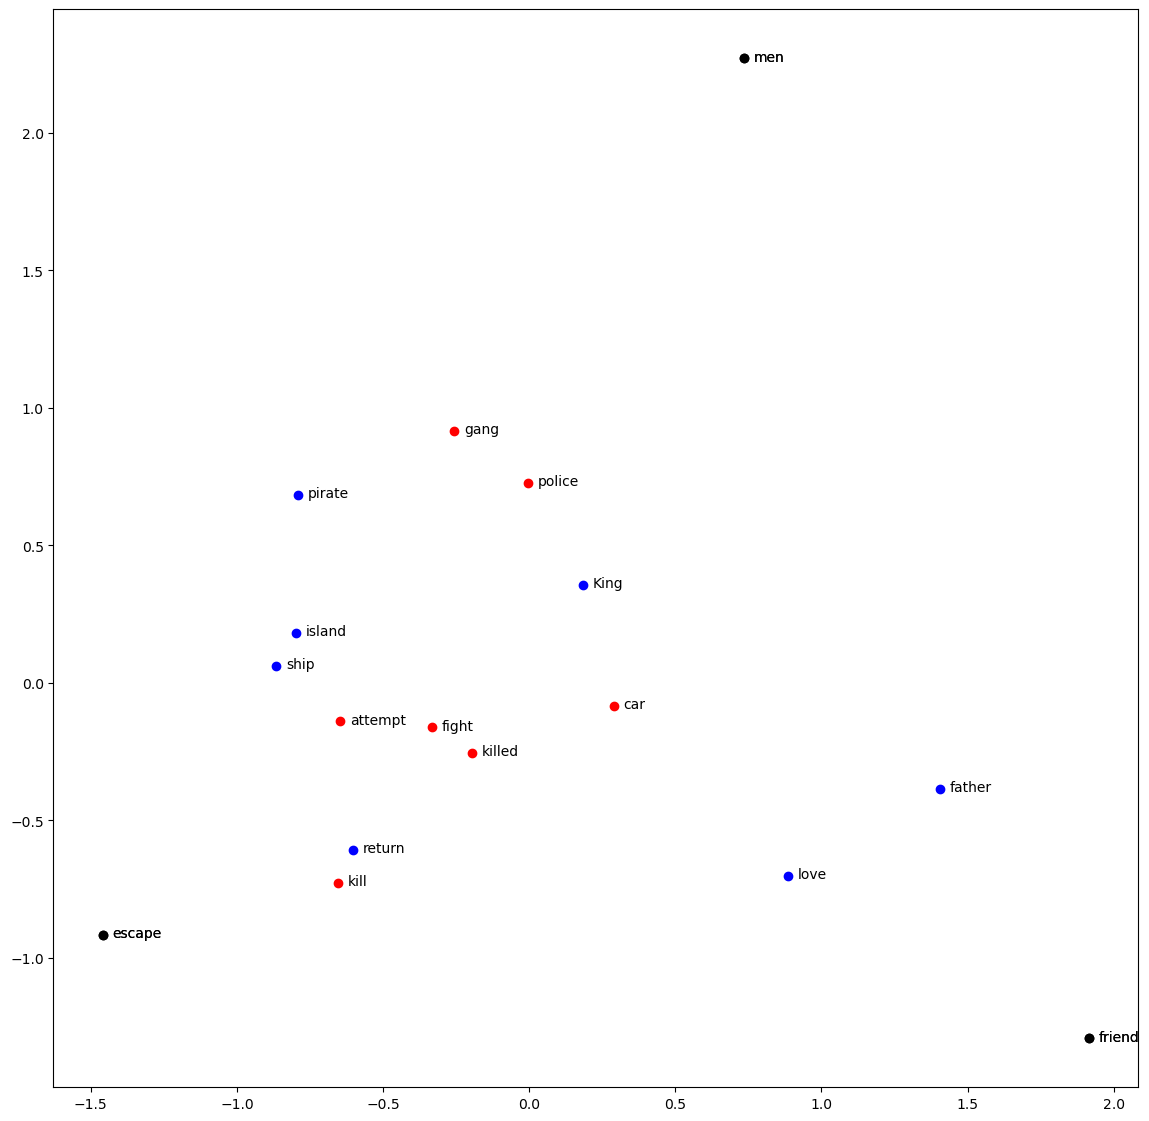

In [52]:
def printKeyValueInWordPair(localDict):
    for key in localDict:
        pairStr = key + localDict[key]
        print("{:10} {:8}".format(key, localDict[key]))
def dupeList(localDict):
    l1 = list(localDict.keys())
    l2 = list(localDict.values())
    shared = [token for token in l1 if token in l2]
    return shared

        
#Options: comedy, drama, adventure, fantasy, horror, mystery, romance,action, thriller, western

#wordPairs = getTwoDictionary("western","romance") #interesting result with 20 values
#wordPairs = getTwoDictionary("action","adventure") #predicatble w/10, less so w/20
totalPairs = 10
wordPairs = getTwoDictionary('action', 'adventure')
wordPairs = dict(list(wordPairs.items())[:totalPairs]) #creates dictionary only creating top x of pairs 
dupeL = dupeList(wordPairs)

#print usefull text 
print("key-values in dict:", len(wordPairs))
print("shared tokens:", len(dupeL))
print("manual search: ")
#print(dupeList(wordPairs))
printKeyValueInWordPair(wordPairs) #comment out if list is too much

size = (14,14)
graphSize = {"x":size[0], "y":size[1]}
createWordVecGraph(wordPairs, dupeL, graphSize)


### Generate dictionary (manual)
- takes input from user to create plaintext in python dictionary format to set wordPairs var above
- note: basically not needed to compare genres anymore, still useful if copy and pasting random or not yet considered text (outside of genre freq list"

In [33]:
# take input and print out the key value thingie 

a1 = input()
a2 = input()

police killed gang kill car fight escape death kills takes
ship love King island crew takes Tarzan time killed finds


In [34]:
a1L = a1.split(" ")
a2L = a2.split(" ")

myPair = ''
for i in range(len(a1L)):
    myPair += '"' + a1L[i] + '"' + ":" + '"' + a2L[i] + '"' + ",  "
myPair = myPair[:-3]
print(myPair)


"police":"ship",  "killed":"love",  "gang":"King",  "kill":"island",  "car":"crew",  "fight":"takes",  "escape":"Tarzan",  "death":"time",  "kills":"killed",  "takes":"finds"
